Ref: 
- https://www.benardmakaa.com/wp-content/uploads/2018/05/Translational-Mechanical-Systems-Extra-Notes-Nise.pdf

In [1]:
pwd

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import tensorflow as tf
import numpy as np

## Reproducable versions
print("TF Version: ", tf.__version__) ## 2.10.0
print("NP Version: ", np.__version__) ## 1.21.6

TF Version:  2.10.0
NP Version:  1.21.6


In [5]:
from tensorflow.python.ops import math_ops

from tensorflow.python.ops.math_ops import Sum, squared_difference

import tensorflow.keras.backend as K
import numpy as np

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math

import time

### Creating folders for saving results

In [6]:
import datetime
def create_folders():
    time_stamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

#     Folder_Name = "PINN_Mech_Sys_"+str(Fm_0)+"_"+str(B)+"_"+str(round(Ks, 2))+"_"+str(M)+"_"+Damped_Flag+"_"+str(epochs)+"_TS"+str(time_stamp)
    Folder_Name = "PINN_Mech_Sys_TS"+str(time_stamp)

    #     print(Folder_Name)


    import os
    import os.path

    os.chdir(".")
    # print("current dir is: %s" % (os.getcwd()))

    if os.path.isdir(Folder_Name):
        print("Folder Exists")
    else:
        os.mkdir(Folder_Name)
        #print("Folder Created")
        


    path = Folder_Name+'/img'
    try:
        os.mkdir(path)
    except :
        pass
    return Folder_Name

### Theorically Calculated (Actual Solution)

In [7]:
1/0.3

3.3333333333333335

Amplitude = 14.1595, 
Alpha = 0.07, Wo = 1.4142
Alpha2: 0.0049, Wo2: 2.0
Under Damped


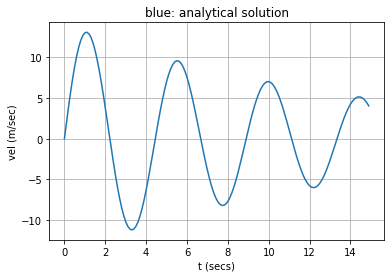

In [8]:
# B = 1.2  -> 6
# M = 1.5  
# Ks = 1/0.3 
# Fm_0 = 12.0


B = 0.7 ## N-s/m
M = 5.0  ## kg or N-s2/m
Ks = 10.0  ## N/m
Fm_0 = 100.0 ## N

# B = 1.2 # -> 6
# M = 1.5  
# Ks = 10
# Fm_0 = 20.0



alpha = B/(2*M)
Wo = math.sqrt(Ks/M)
z = math.sqrt(abs((alpha**2)-(Wo**2)))

Amp = (Fm_0/(z*M))
print("Amplitude = {}, \nAlpha = {}, Wo = {}".format(round(Amp,4), round(alpha, 4), round(Wo, 4)))
print("Alpha2: {}, Wo2: {}".format(round((B/(2*M))**2, 4), round(Ks/M, 4)))

Damped_Flag = None

if alpha**2 > Wo**2:
    print("Over Damped")
    Damped_Flag = "OVER"
    
elif alpha**2 < Wo**2:
    print("Under Damped")
    Damped_Flag = "UNDER"
elif alpha**2 == Wo**2:
    print("Critically Damped")
    Damped_Flag = "CRITICAL"

###############################################################
num_test_pts = 150
t_test = np.zeros(num_test_pts)
vel_calc = np.zeros(num_test_pts)

for i in range(num_test_pts):
    t_test[i] = i / 10.0  # total time = t_test[num_test_pts]
    # choose one matching the chosen circuit parameter set
    
    if Damped_Flag == "OVER":
        vel_calc[i] = (Fm_0/(2*z*M)) * ((math.exp((-alpha + z)*t_test[i]))-(math.exp((-alpha - z)*t_test[i]))) # over-damped
    
    elif Damped_Flag == "UNDER":
        vel_calc[i] = (Fm_0/(z*M)) * math.exp(-alpha * t_test[i]) * np.sin(z * t_test[i])  # under-damped
    
    elif Damped_Flag == "CRITICAL":
        vel_calc[i] = (Fm_0 / M) * t_test[i] * math.exp(-1 * alpha * t_test[i])  # critically-damped
    

plt.plot(t_test, vel_calc)
plt.title('blue: analytical solution')
plt.xlabel('t (secs)')
plt.ylabel('vel (m/sec)')
plt.grid()
plt.show()

## Neural Network Implimentation

In [9]:
optimizer = Adam(learning_rate=0.001)
weight_init = RandomNormal()

# Build model
inputs = tf.keras.Input(batch_size= 10, shape=(1,), name="input_layer")
x = layers.Dense(64, activation='gelu', kernel_initializer=weight_init,
                 kernel_regularizer=None)(inputs)

x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64, activation='gelu', kernel_initializer=weight_init,
                 kernel_regularizer=None)(x)

x = layers.Dense(64, activation='gelu', kernel_initializer=weight_init,
                 kernel_regularizer=None)(x)

output = layers.Dense(1, activation='linear', kernel_initializer=weight_init)(x)

model = tf.keras.Model(inputs, output)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(10, 1)]                 0         
                                                                 
 dense (Dense)               (10, 64)                  128       
                                                                 
 batch_normalization (BatchN  (10, 64)                 256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (10, 64)                  0         
                                                                 
 dense_1 (Dense)             (10, 64)                  4160      
                                                                 
 dense_2 (Dense)             (10, 64)                  4160      
                                                             

In [11]:
################## sampling interval ###########################
# co-location points
t_coloc_max = 7
t_coloc_intervel = 0.1
t_coloc = np.arange(0, t_coloc_max, t_coloc_intervel)  # define domain

# initial conditions:
#  v(t) initial conditions
t_init = np.array([0.0])  # time, sec
vel_init = np.array([0.0])  # velocity, m/sec

#  v'(t) initial conditions
t_init2 = np.array([0.0])  # time, sec
F_init2 = np.array([Fm_0])  # d/dt(vel) * M = Fm_0

t_init2 = tf.convert_to_tensor(t_init2)
t_init2 = tf.reshape(t_init2, [1, 1])
t_init2 = tf.Variable(t_init2, name='t_init2')

# Step function
def step(t_coloc, vel_train_true, t_init, vel_init, t_init2, F_init2):

# def step(t_coloc, t_init, vel_init, t_init2, F_init2):
    t_coloc = tf.convert_to_tensor(t_coloc)
    t_coloc = tf.reshape(t_coloc, [batch_size, 1])  # required by keras input
    t_coloc = tf.Variable(t_coloc, name='t_coloc')
    with tf.GradientTape(persistent=True) as tape:
        
        # model_loss1: initial condition vel_init @ t_init -> v(t) initial condition
        pred_init = model(t_init)
        model_loss1 = math_ops.squared_difference(pred_init, vel_init)
#         print("vel_init: ", float(vel_init), " pred_init: ",float(pred_init), " model_loss1: ",float(model_loss1))
        
        # model_loss2: initial condition F_init2 @ t_init2 -> v'(t) initial condition
#         t_init2 = tf.convert_to_tensor(t_init2)
#         t_init2 = tf.reshape(t_init2, [1, 1])
#         t_init2 = tf.Variable(t_init2, name='t_init2')
        pred_init2 = model(t_init2)
        
        dvdt = tape.gradient(pred_init2, t_init2)  # v'(t)
        
        Fm = dvdt * tf.cast(M, tf.float64)  # Mass force due to dvdt
        model_loss2 = math_ops.squared_difference(Fm, F_init2)
        model_loss2 = tf.cast(model_loss2, tf.float32)
#         print("F_init2: ", float(F_init2), " pred_Fm: ",float(Fm), " model_loss2: ",float(model_loss2))
        
       
        # 1st and 2nd order gradients for co-location pts
        with tf.GradientTape(persistent=True) as tape2:
            pred_y = model(t_coloc)
            dvdt = tape2.gradient(pred_y, t_coloc)  # v'(t)
        dvdt2 = tape2.gradient(dvdt, t_coloc)  # v"(t)
        
        # model_loss3: collocation points
        pred_y = tf.cast(pred_y, tf.float64)
        residual = dvdt2 + dvdt * (B / M) + pred_y / (M / Ks)
        model_loss3 = K.mean(math_ops.square(residual), axis=-1)
        model_loss3 = tf.cast(model_loss3, tf.float32)
#         print("residual: ", float(residual), " model_loss3: ",float(model_loss3))
        
        
#         # model_loss4: custom condition vel_val -> v(t)
#         # model_loss4: custom condition vel_val @ t = 10 sec -> v(10) initial condition
#         pred_vel_train = model(t_coloc)
#         model_loss4 = math_ops.squared_difference(pred_vel_train, vel_train_true)
#         print("t_coloc: ", float(t_coloc), " vel_train_true: ", vel_train_true, " pred_vel_train: ",float(pred_vel_train), " model_loss4: ",float(model_loss4))
        
    
        #total loss
        model_loss = model_loss1 + model_loss2 +  model_loss3 #+ model_loss4
        print("model_loss: ", float(np.mean(model_loss.numpy())))
        
        trainable = model.trainable_variables
        model_gradients = tape.gradient(model_loss, trainable)

        # Update model
        optimizer.apply_gradients(zip(model_gradients, trainable))
        
    return float(np.mean(model_loss.numpy()))

In [12]:
vel_train_true = np.zeros(len(t_coloc))
vel_train_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [13]:
t_coloc

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9])

In [14]:
for i in range(len(t_coloc)):
    # choose one matching the chosen circuit parameter set
    
    if Damped_Flag == "OVER":
        vel_train_true[i] = (Fm_0/(2*z*M)) * ((math.exp((-alpha + z)*t_coloc[i]))-(math.exp((-alpha - z)*t_coloc[i]))) # over-damped
    
    elif Damped_Flag == "UNDER":
        vel_train_true[i] = (Fm_0/(z*M)) * math.exp(-alpha * t_coloc[i]) * np.sin(z * t_coloc[i])  # under-damped
    
    elif Damped_Flag == "CRITICAL":
        vel_train_true[i] = (Fm_0 / M) * t_coloc[i] * math.exp(-1 * alpha * t_coloc[i])  # critically-damped

In [15]:
vel_train_true

array([  0.        ,   1.97945153,   3.8921361 ,   5.70105805,
         7.3717934 ,   8.87313666,  10.17767481,  11.26227809,
        12.1084991 ,  12.70287341,  13.03711732,  13.10822004,
        12.91843007,  12.47513755,  11.79065619,  10.88191072,
         9.77003717,   8.47990528,   7.03957346,   5.47968813,
         3.83284013,   2.13289145,   0.41428617,  -1.28864057,
        -2.94234183,  -4.51471308,  -5.97570871,  -7.29790913,
        -8.45702788,  -9.43234972, -10.20709158, -10.76868079,
       -11.10894574, -11.22421674, -11.11533623, -10.78757929,
       -10.25048747,  -9.51762027,  -8.60623042,  -7.53687047,
        -6.3329394 ,  -5.02017913,  -3.62613148,  -2.17956713,
        -0.70989806,   0.75341456,   2.18144516,   3.54636987,
         4.82200286,   5.98429282,   7.01177009,   7.88593653,
         8.59159093,   9.11708462,   9.454503  ,   9.59977059,
         9.55267847,   9.31683462,   8.89953937,   8.31158928,
         7.56701451,   6.68275564,   5.67828731,   4.57

### Extracting datapoints from Analytical Solution

In [16]:
vel_train_true = np.zeros(len(t_coloc))
vel_train_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [17]:
for i in range(len(t_coloc)):
    # analytical results for comparison to PINN result
    
    if Damped_Flag == "OVER":
        vel_train_true[i] = (Fm_0/(2*z*M)) * ((math.exp((-alpha + z)*t_coloc[i]))-(math.exp((-alpha - z)*t_coloc[i]))) # over-damped
    
    elif Damped_Flag == "UNDER":
        vel_train_true[i] = (Fm_0/(z*M)) * math.exp(-alpha * t_coloc[i]) * np.sin(z * t_coloc[i])  # under-damped
    
    elif Damped_Flag == "CRITICAL":
        vel_train_true[i] = (Fm_0 / M) * t_coloc[i] * math.exp(-1 * alpha * t_coloc[i])  # critically-damped

In [18]:
len(vel_train_true)

70

In [19]:
len(t_coloc)/2

35.0

In [20]:
batch_size = int(len(t_coloc)/2)
batch_size

35

In [21]:
from tqdm import tqdm
from IPython import display

In [22]:
import matplotlib.pyplot as plt

In [23]:
def epoch_loss_graph(epoch_losses):
    fig = plt.figure(figsize=(9,6))
    plt.semilogy(list(range(len(epoch_losses))), epoch_losses,'k-')
    
    plt.title('Model Loss plot for each Epoch(Training count)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.grid()

### Training the PINN Model

- Training to learn Boundary conditions
- Regularization loss with involved physics Partial Differential Equations (PDE)

In [24]:
epochs = 10000

In [25]:
Folder_Name = create_folders()
Folder_Name

'PINN_Mech_Sys_TS20230614104153'

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [27]:
Folder_Name

'PINN_Mech_Sys_TS20230614104153'

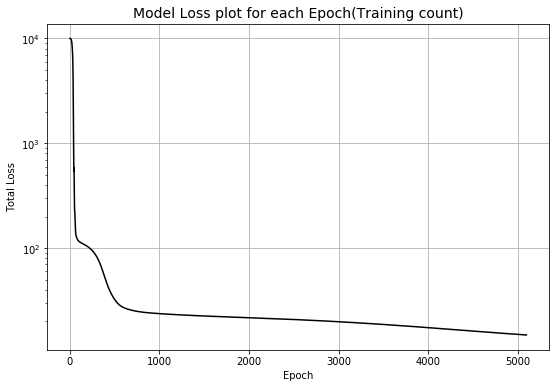

 51%|██████████████████████████████████████▏                                    | 5095/10000 [1:00:20<56:20,  1.45it/s]

model_loss:  19.79701805114746
model_loss:  9.89901351928711

In [ ]:
# Training loop

epoch_pred = []
epoch_losses = []
best_loss = np.inf

bat_per_epoch = math.floor(len(t_coloc) / batch_size)
t_train_start = time.time()

for epoch in tqdm(range(epochs)):
    t1 = time.time()
    batch_losses = []
    for i in range(bat_per_epoch):
        n = i * batch_size
        ### Training 
        step_loss = step(t_coloc[n:n + batch_size], vel_train_true[n:n+batch_size] ,t_init, vel_init, t_init2, F_init2)
        
        ### Test Loss
        batch_losses.append(step_loss)
    
    train_predictions = list((model.predict([t_coloc], verbose = 0)).reshape(1, -1)[0])
    print("Train Predictions: \n", train_predictions)
    epoch_pred.append(train_predictions)
    
    epoch_losses.append(np.mean(batch_losses))
    
    current_loss = np.mean(batch_losses)
    print("Current Loss: ", current_loss)
    print("Best Loss   : ", best_loss)
    
    if current_loss < best_loss:
        
        best_loss = current_loss
        
        print("This is Best epoch: {} with epoch loss: {}".format(epoch, current_loss))
        # save model
        model.save(Folder_Name+"/"+'PINN_Exp_Model.h5')
        print('Model Saved!')
        print("Folder_Name", Folder_Name)
        savedModel=load_model(Folder_Name+"/"+'PINN_Exp_Model.h5')
        saved_model_predictions = list((savedModel.predict([t_coloc], verbose = 0)).reshape(1, -1)[0])
        print("Saved Model Predictions: \n", saved_model_predictions)
    
    epoch_loss_graph(epoch_losses)
    display.clear_output(wait=True)
    plt.show()    

print("Total training time (min) took for {} epochs: ".format(epochs), round((time.time() - t_train_start)/60, 3))

In [ ]:
Damped_Flag

In [ ]:
saved_model_predictions

In [ ]:
savedModel=load_model(Folder_Name+"/"+'PINN_Exp_Model.h5')
list((savedModel.predict([t_coloc], verbose = 0)).reshape(1, -1)[0])


In [ ]:
# savedModel=load_model(Folder_Name+"/"+'PINN_Exp_Model.h5')
list((model.predict([t_coloc], verbose = 0)).reshape(1, -1)[0])


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
fig = plt.figure(figsize=(9,6))

plt.title('Model Loss plot for each Epoch(Training count)', fontsize=14)
plt.semilogy(list(range(len(epoch_losses))), epoch_losses,'k-')

plt.xlabel('Epoch')
plt.ylabel('Total Loss')

plt.grid()

image_name = Folder_Name+'/Epoch_Loss_Plot.png'
plt.savefig(image_name)

### Extracting Training Results

In [ ]:
import imageio
import matplotlib.patches as mpatches
from IPython import display

frames = []
for i, epoch_data in enumerate(epoch_pred[:]):
    if i%50 == 0:
        print("Epoch {} of {}".format(i, len(epoch_pred)))
        
        fig = plt.figure(figsize=(9,6))
        plt.title('Speed v (mps) and time (sec) at epoch {}'.format(i), fontsize=14)
        plt.plot(t_coloc, epoch_data, 'r', t_coloc, vel_train_true, 'b')
        
        
        plt.xlabel('t (secs)')
        plt.ylabel('v (mps)')
        red_patch = mpatches.Patch(color='blue', label='Theoretical actual v(t)')
        blue_patch = mpatches.Patch(color='red', label='PINN predicted v(t)')
        plt.legend(handles=[red_patch, blue_patch])

        plot_threshold = (math.ceil(max(vel_train_true)) - round(min(vel_train_true))) * 0.25

        plt.ylim(round(min(vel_train_true)) - plot_threshold, math.ceil(max(vel_train_true))+plot_threshold)
        plt.grid()

        image_name = Folder_Name+'/img/img_{}.png'.format(i)
        plt.savefig(image_name, 
                    transparent = False,  
                    facecolor = 'white'
                   )
        plt.close()
        plt.show()
        image = imageio.imread(Folder_Name+'/img/img_{}.png'.format(i))
        frames.append(image)

imageio.mimsave(Folder_Name+'/curve_fitting_graph_during_training.gif', # output gif
                frames,          # array of input frames
                fps = 10,         # optional: frames per second
#                 loop = 1
               )

### Training Evolution

In [ ]:
def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

show_gif(Folder_Name+"/"+'curve_fitting_graph_during_training.gif')

### Saving and Loading PINN Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [ ]:
# save model
model.save(Folder_Name+"/"+'PINN_Exp_Model.h5')
print('Model Saved!')

In [ ]:
# load model
savedModel=load_model(Folder_Name+"/"+'PINN_Exp_Model.h5')
savedModel.summary()

### Validating the loaded PINN model performance

In [ ]:
num_test_pts = 300

In [ ]:
t_test = np.zeros(num_test_pts)
vel_test = np.zeros(num_test_pts)
vel_calc = np.zeros(num_test_pts)

In [ ]:
len(t_coloc), len(vel_train_true)

In [ ]:
len(vel_calc)

In [ ]:
len(t_test), len(t_coloc), num_test_pts

In [ ]:
for i in range(num_test_pts):
    t_test[i] = i / 10.0  
    
    # PINN results
    vel_test[i] = savedModel.predict([t_test[i]], verbose = 0)  # PINN results
    
    ### Analytical Results
    if Damped_Flag == "OVER":
        vel_calc[i] = (Fm_0/(2*z*M)) * ((math.exp((-alpha + z)*t_test[i]))-(math.exp((-alpha - z)*t_test[i]))) # over-damped
    
    elif Damped_Flag == "UNDER":
        vel_calc[i] = (Fm_0/(z*M)) * math.exp(-alpha * t_test[i]) * np.sin(z * t_test[i])  # under-damped
    
    elif Damped_Flag == "CRITICAL":
        vel_calc[i] = (Fm_0 / M) * t_test[i] * math.exp(-1 * alpha * t_test[i])  # critically-damped

In [ ]:
fig = plt.figure(figsize=(9,6))
plt.plot(t_test, vel_test, 'r', t_test, vel_calc, 'b', t_coloc, vel_train_true, 'Dg')
plt.title('red: PINN   blue: analytical solution   green: co-location pts')
plt.xlabel('t (secs)')
plt.ylabel('vel (m/sec)')
plt.grid()

image_name = Folder_Name+'/Model_Test_Prediction.png'
plt.savefig(image_name)

plt.show()

# Save result data to file
# pinn_data = np.stack((t_test, vel_test), axis=1)
# np.save('[insert path here]/pinn_data.npy', pinn_data)

# TO DO

- ADD MORE LAYERS ./
- CREATE A DATA SET AND IMPLEMENT PINN-RNN USE CASE

- CONTACT SOMEONE TO SOLVE THIS PINN ISSUE
